Here i am following https://github.com/NREL/hsds-examples/blob/master/notebooks/01_WTK_introduction.ipynb

In [20]:
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dateutil
from pyproj import Proj

In [2]:
f = h5pyd.File("/nrel/wtk-us.h5", 'r')

In [ ]:
/api/cleap/v1

In [4]:
list(f.attrs)

['history']

In [5]:
f.attrs['history']

'Produced by 3TIER, Inc. under NREL subcontract AGV-2-22460-01'

In [6]:
list(f)

['inversemoninobukhovlength_2m',
 'status',
 'windspeed_10m',
 'temperature_80m',
 'temperature_160m',
 'temperature_200m',
 'pressure_200m',
 'DIF',
 'temperature_10m',
 'winddirection_120m',
 'windspeed_120m',
 'windspeed_140m',
 'temperature_60m',
 'relativehumidity_2m',
 'windspeed_200m',
 'temperature_140m',
 'precipitationrate_0m',
 'winddirection_160m',
 'pressure_0m',
 'GHI',
 'windspeed_80m',
 'winddirection_100m',
 'temperature_2m',
 'temperature_40m',
 'coordinates',
 'winddirection_60m',
 'windspeed_160m',
 'winddirection_40m',
 'winddirection_10m',
 'DNI',
 'winddirection_200m',
 'windspeed_60m',
 'datetime',
 'pressure_100m',
 'windspeed_40m',
 'temperature_120m',
 'windspeed_100m',
 'winddirection_140m',
 'temperature_100m',
 'winddirection_80m']

In [8]:
dset = f['windspeed_100m']
dset.shape

(61368, 1602, 2976)

size of dataset in TB

In [9]:
dset.shape[0] * dset.shape[1] * dset.shape[2] * 4 * 10**-12  # aprox 1 TB per dataset!

1.170300524544

size of chunks in MB

In [11]:
print(dset.chunks)
dset.chunks[0] * dset.chunks[1] * dset.chunks[2] * 4 * 10**-6 # aprox 1.5 MB per chunk

(24, 89, 186)


1.589184

get datetimes

In [13]:
dt = f["datetime"]
dt = pd.DataFrame({"datetime": dt[:]},index=range(0,dt.shape[0]))
dt['datetime'] = dt['datetime'].apply(dateutil.parser.parse)
dt.head()

,datetime
0,2007-01-01 00:00:00
1,2007-01-01 01:00:00
2,2007-01-01 02:00:00
3,2007-01-01 03:00:00
4,2007-01-01 04:00:00


In [14]:
#indices for 2010
twentyten = dt.loc[(dt.datetime >= '2010-01-01') & (dt.datetime < '2011-01-01')].index
twentyten

Int64Index([26304, 26305, 26306, 26307, 26308, 26309, 26310, 26311, 26312,
            26313,
            ...
            35054, 35055, 35056, 35057, 35058, 35059, 35060, 35061, 35062,
            35063],
           dtype='int64', length=8760)

In [15]:
#index for particular date
timestep = dt.loc[dt.datetime == '2012-04-01 12:00:00'].index[0]
timestep

46020

In [16]:
%time data = dset[timestep,::8,::8]   # extract every 8th record at a particular time

CPU times: user 10.8 ms, sys: 3.78 ms, total: 14.6 ms
Wall time: 2.52 s


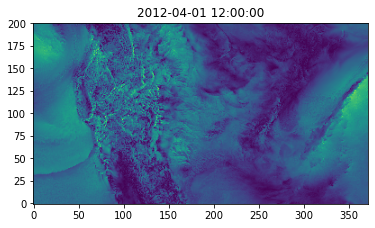

In [17]:
plt.title(str(dt.loc[timestep,"datetime"]))
plt.imshow(data, origin="lower")

In [18]:
%time data = dset[timestep,1100:1400,2000:2400]  # full-resolution subset

CPU times: user 16.5 ms, sys: 5.34 ms, total: 21.9 ms
Wall time: 1.73 s


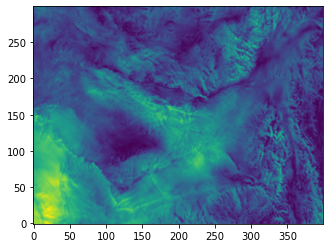

In [19]:
plt.imshow(data, origin="lower")

NameError: name 'select_df' is not defined

In [21]:
# This function finds the nearest x/y indices for a given lat/lon.
# Rather than fetching the entire coordinates database, which is 500+ MB, this
# uses the Proj4 library to find a nearby point and then converts to x/y indices
def indicesForCoord(f, lat_index, lon_index):
    dset_coords = f['coordinates']
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
    projectLcc = Proj(projstring)
    origin_ll = reversed(dset_coords[0][0])  # Grab origin directly from database
    origin = projectLcc(*origin_ll)
    
    coords = (lon_index,lat_index)
    coords = projectLcc(*coords)
    delta = np.subtract(coords, origin)
    ij = [int(round(x/2000)) for x in delta]
    return tuple(reversed(ij))

NewYorkCity = (40.7128, -74.0059)
NewYorkCity_idx = indicesForCoord( f, NewYorkCity[0], NewYorkCity[1] )

print("y,x indices for New York City: \t\t {}".format(NewYorkCity_idx))
print("Coordinates of New York City: \t {}".format(NewYorkCity))
print("Coordinates of nearest point: \t {}".format(f["coordinates"][NewYorkCity_idx[0]][NewYorkCity_idx[1]]))

y,x indices for New York City: 		 (1044, 2375)
Coordinates of New York City: 	 (40.7128, -74.0059)
Coordinates of nearest point: 	 (40.709702, -73.992798)


In [22]:
# Get the entire 2010 timeseries data for a point in NYC
%time tseries = dset[min(twentyten):max(twentyten)+1, NewYorkCity_idx[0], NewYorkCity_idx[1]]

CPU times: user 8.67 ms, sys: 2.61 ms, total: 11.3 ms
Wall time: 1.94 s


In [23]:
len(tseries)   # 1 years * 365 days * 24 hours

8760

Text(0.5, 1.0, 'NYC Windspeed in 2010')

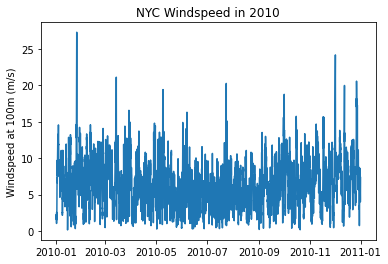

In [24]:
plt.plot(dt.iloc[twentyten,].datetime, tseries)
plt.ylabel("Windspeed at 100m (m/s)")
plt.title("NYC Windspeed in 2010")

In [25]:
# Fetch full timeseries data for all seven years
LongsPeak_idx = indicesForCoord(f, 40.2549, -105.6160)
%time tseries = dset[:,LongsPeak_idx[0],LongsPeak_idx[1]]

CPU times: user 25.1 ms, sys: 4.17 ms, total: 29.3 ms
Wall time: 10.3 s


Text(0.5, 1.0, 'Longs Peak Windspeed 2007-2013')

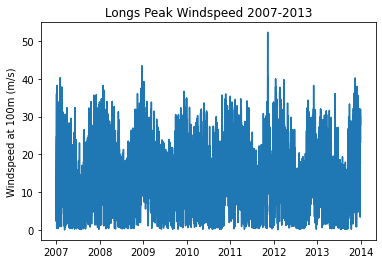

In [26]:
plt.plot(dt.datetime, tseries)
plt.ylabel("Windspeed at 100m (m/s)")
plt.title("Longs Peak Windspeed 2007-2013")

# windspeed stats

In [27]:
dt["windspeed"] = tseries
dt["year"] = dt["datetime"].apply(lambda x: x.year)
dt["month"] = dt["datetime"].apply(lambda x: x.month)
dt["day"] = dt["datetime"].apply(lambda x: x.day)
dt["hour"] = dt["datetime"].apply(lambda x: x.hour)

In [28]:
agg = dt.groupby(["month","hour"]).mean()
agg = agg.reset_index().pivot(index="month",columns="hour",values="windspeed")
agg

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
month,,,,,,,,,,,,,,,,,,,,,
1,17.782742,17.781574,17.936460,17.981829,17.954967,18.106070,18.217442,18.367193,18.447174,18.534664,...,18.363831,18.178539,17.854143,17.431709,17.194565,17.027246,16.904301,16.998867,17.139912,17.422821
2,16.437485,16.639477,16.689278,16.629135,16.662443,16.965656,17.273306,17.460009,17.616871,17.667582,...,17.730576,17.413107,17.092430,16.651268,16.390566,16.220219,16.195864,16.077782,16.211063,16.287605
3,14.604921,15.130107,15.412607,15.489409,15.776677,16.043848,16.277828,16.474186,16.677057,16.629452,...,16.498095,16.084057,15.284851,14.944521,14.798256,14.730160,14.745756,14.960455,14.894045,14.823627
4,13.538098,13.942963,14.095672,14.382008,14.624935,14.589562,14.894791,15.148313,15.371621,15.806626,...,15.633238,14.803759,14.014667,13.467426,13.230791,13.364985,13.376946,13.591709,13.539725,13.335716
5,11.307108,11.303395,11.524436,11.436130,11.292299,11.719445,11.939952,11.890996,12.257992,12.596297,...,12.245151,11.770721,11.352464,11.030233,11.190969,11.271287,11.059191,11.392616,11.504339,11.454047
6,12.146861,11.924526,11.722508,11.499505,11.589317,11.590261,11.332961,11.392022,11.676019,12.099078,...,11.952153,11.572066,11.499331,11.411350,11.469437,11.594026,11.791553,12.379775,12.270243,12.375328
7,7.504178,7.493124,7.438205,7.311883,7.368392,7.312094,7.841232,7.848489,7.851456,8.082863,...,8.146431,7.786299,7.660076,7.651398,7.561840,7.867813,8.126966,8.486354,7.907937,7.684139
8,8.010785,8.004921,7.972166,7.861540,7.758930,8.114224,8.464076,8.491234,8.781244,9.044336,...,9.444621,9.003101,8.690378,8.655358,8.424558,8.409269,8.399918,8.803268,8.915976,8.636556
9,9.860007,9.619100,9.669471,10.028005,10.206232,10.343493,10.769067,11.195759,11.499839,11.649380,...,11.362492,10.789354,10.624351,10.473779,10.323612,10.251211,10.327231,10.510371,10.489648,10.150558


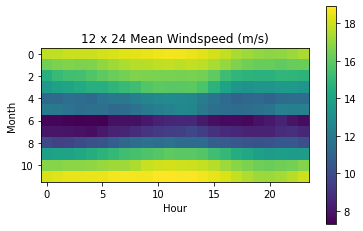

In [29]:
plt.imshow(agg)
plt.xlabel("Hour")
plt.ylabel("Month")
plt.title("12 x 24 Mean Windspeed (m/s)")
plt.colorbar()